## Analysis of an E-commerce Dataset Part 3 (s2 2023)


In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the ratings have been converted to like (with score 1) and dislike (with score 0). Your task is to train classification models such as KNN to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item | helpfulness | gender | category | item_id | item_price | user_city | rating |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
    
Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the like (corresponding to rating 1) and dislike (corresponding to rating 0) in the data from some of the other fields. More specifically, you need to complete the following major steps: 
- 1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
- 2) Convert object features into digit features by using an encoder
- 3) Study the correlation between these features. 
- 4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
- 5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
- 6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.
    

# Task 1

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
%matplotlib inline

# Exploring the Data

In [83]:
df = pd.read_csv('files/portfolio_3.csv')

In [84]:
df.head()

,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
0,4081,71900,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0
2,4081,72000,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1
4,4081,100399,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   helpfulness  2685 non-null   int64  
 5   gender       2685 non-null   object 
 6   category     2685 non-null   object 
 7   item_id      2685 non-null   int64  
 8   item_price   2685 non-null   float64
 9   user_city    2685 non-null   int64  
 10  rating       2685 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 230.9+ KB


there is no null values, it means there is no missing values that we need to replace.

In [86]:
df.describe()

,userId,timestamp,helpfulness,item_id,item_price,user_city,rating
count,2685.000000,2685.000000,2685.000000,2685.000000,2685.000000,2685.000000,2685.000000
mean,4673.237616,58812.687151,3.908007,43.478585,83.091650,19.456983,0.639851
std,3517.893437,37013.726118,0.289069,26.630426,42.227558,11.397281,0.480133
min,4.000000,10100.000000,3.000000,0.000000,12.000000,0.000000,0.000000
25%,1310.000000,22000.000000,4.000000,21.000000,49.000000,9.000000,0.000000
50%,4666.000000,52800.000000,4.000000,42.000000,73.650000,19.000000,1.000000
75%,7651.000000,91000.000000,4.000000,67.000000,129.820000,28.000000,1.000000
max,10779.000000,123199.000000,4.000000,88.000000,149.000000,39.000000,1.000000


In [87]:
df.shape

(2685, 11)

# Cleaning the Data

First we should check if there is any abnormal instances or missing values.
In order to find out if there is abnormal instances, we can use box plots.

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'userId'),
  Text(2, 0, 'timestamp'),
  Text(3, 0, 'helpfulness'),
  Text(4, 0, 'item_id'),
  Text(5, 0, 'item_price'),
  Text(6, 0, 'user_city'),
  Text(7, 0, 'rating')])

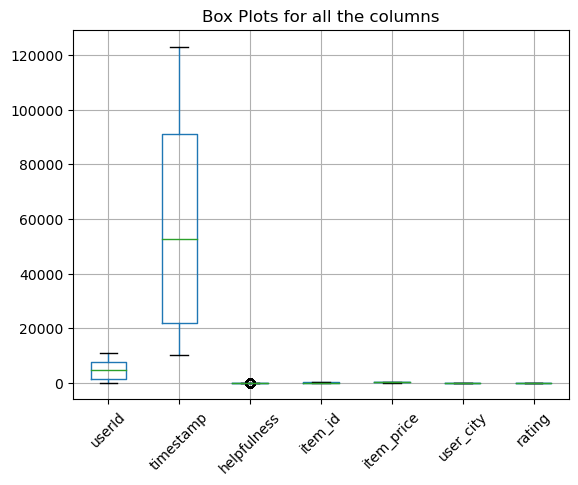

In [88]:
df.boxplot()
plt.title("Box Plots for all the columns")
plt.xticks(rotation=45)

As we can see, helpfulness has outliers that we should remove them

(array([1]), [Text(1, 0, 'helpfulness')])

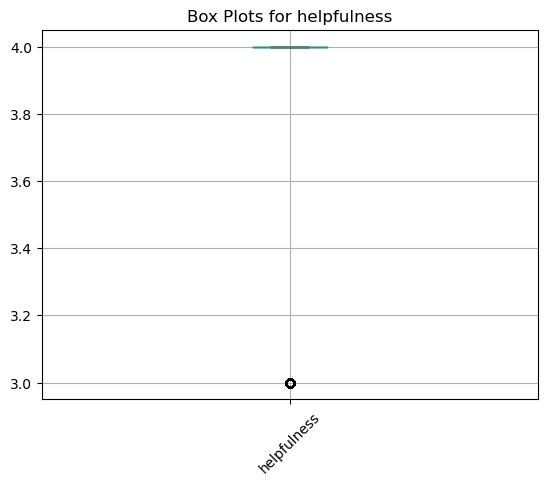

In [89]:
columns = ['helpfulness']
df[columns].boxplot()
plt.title("Box Plots for helpfulness")
plt.xticks(rotation=45)

so any helpfulness value that is lower than 4 must be removed.

In [90]:
cleaned_df = df[df['helpfulness'] == 4]

# Task 2

**Convert object features into digit features by using an encoder.**

In this task we should convert review, item, gender and category into digits.

In [91]:
enc = OrdinalEncoder()
df_new = cleaned_df.copy()
df_new[['review', 'category', 'gender','item']] = enc.fit_transform(df_new[['review', 'category', 'gender','item']])

# Task 3

**Study the correlation between these features.**

In [92]:
df_new[['helpfulness','gender','category','review','rating','timestamp','item_id','item_price','user_city','userId']].corr()

,helpfulness,gender,category,review,rating,timestamp,item_id,item_price,user_city,userId
helpfulness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,NaN,1.000000,0.022965,-0.036737,-0.019109,-0.005701,0.000703,-0.051869,-0.068108,-0.038536
category,NaN,0.022965,1.000000,0.011270,-0.146022,0.011962,-0.048688,-0.111538,-0.001592,-0.054610
review,NaN,-0.036737,0.011270,1.000000,-0.037373,-0.006058,0.173589,-0.039548,0.049058,0.006841
rating,NaN,-0.019109,-0.146022,-0.037373,1.000000,0.001893,0.057821,0.012540,-0.023899,0.070893
timestamp,NaN,-0.005701,0.011962,-0.006058,0.001893,1.000000,-0.003594,0.020206,-0.011367,-0.070805
item_id,NaN,0.000703,-0.048688,0.173589,0.057821,-0.003594,1.000000,-0.062491,-0.001383,-0.012764
item_price,NaN,-0.051869,-0.111538,-0.039548,0.012540,0.020206,-0.062491,1.000000,-0.025975,0.022551
user_city,NaN,-0.068108,-0.001592,0.049058,-0.023899,-0.011367,-0.001383,-0.025975,1.000000,-0.058863
userId,NaN,-0.038536,-0.054610,0.006841,0.070893,-0.070805,-0.012764,0.022551,-0.058863,1.000000


The correlation of helpfulness with other columns is NaN, because it is a constant value for all the rows.

# Task 4

**Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.**

**Spliting the dataset**

In [93]:
train, test = train_test_split(df_new, test_size=0.2, random_state=42)
y_train = train['rating']
x_train = train[['category','userId']]
y_test = test['rating']
x_test = test[['category','userId']]

Category and userId are chosen because they are the most correlated features with rating.

**Training a logistic regression model**

In [94]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
prediction = logreg.predict(x_test)

**Evaluating the accuracy of our model**

In [95]:
acc = accuracy_score(y_test, prediction)
print(f'Accuracy Score: {acc}')

Accuracy Score: 0.6536885245901639


The accuracy of our model is near to 0.5 that suggests that our model is not performing well.

# Task 5

**Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.**

In [96]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    acc = accuracy_score(y_test, prediction)
    print(f'Accuracy Score: {acc}')

Accuracy Score: 0.5983606557377049


# Task 6 

**Tune the hyper-parameter K in KNN to see how it influences the prediction performance**

**Searching for the best Hyper-parameter K in KNN**

In [97]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    param_grid = {'n_neighbors': list(range(1,100))}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    best_hp = grid_search.best_params_['n_neighbors']
    print(f'Best Hyperparameters: {best_hp}')

Best Hyperparameters: 77


**Training a Model with the Best hyper-parameter K in KNN**

In [98]:
 import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)   
    best_model = KNeighborsClassifier(best_hp)
    best_model.fit(x_train, y_train)
    prediction = best_model.predict(x_test)
    acc = accuracy_score(y_test, prediction)
    print(f'Best Accuracy: {acc}')

Best Accuracy: 0.6495901639344263


Despite finding the best hyper-parameter, our model's accuracy score is only around 0.5, indicating poor performance, even though it did improve slightly.

**As we can see, with the best hyper-parameter K in KNN, the performance of the two models is almost the same.**